In [1]:
library(Seurat)
library(harmony)
library(ggplot2)
library(dplyr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: Rcpp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
samples.md <- read.table("samples-cutoffs.tsv", header=TRUE)

In [3]:
load.subset <- function(h5, project, nFeature.min, nFeature.max, percent.mt.max, sample) {
    so <- CreateSeuratObject(counts = Read10X_h5(h5), project = project)
    so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")
    orig.cells <- ncol(so$RNA)
    so <- subset(so, subset = nFeature_RNA < nFeature.max & nFeature_RNA > nFeature.min & percent.mt < percent.mt.max)
    return(list(seurat=so, orig.cells = orig.cells, kept.cells = ncol(so$RNA), percent.kept = ncol(so$RNA) / orig.cells))
}

In [4]:
load.mergeset <- function(md) {
    subsets <- mapply(FUN=load.subset,
                      sample = md$Sample,
                      h5 = md$H5, 
                      project = md$Sample, 
                      nFeature.min = md$nFeature.min, 
                      nFeature.max = md$nFeature.max,
                      percent.mt = md$percent.mt.max,
                     SIMPLIFY=FALSE)
    seurats <- sapply(subsets, '[[', 'seurat')
    subset.df <- data.frame(
        Sample = md$Sample, 
        percent.kept = sapply(subsets, '[[', "percent.kept"),
        orig.cells = sapply(subsets, '[[', "orig.cells"),
        kept.cells = sapply(subsets, '[[', "kept.cells")
    )
    
    genes.intersection <- rownames(seurats[[1]])
    for (i in 2:length(seurats)) {
        genes.intersection <- intersect(genes.intersection, rownames(seurats[[i]]))
    }

    seurat <- merge(seurats[[1]], y = seurats[-1], add.cell.ids = md$Sample, project = md$Case[1])
    seurat <- seurat[genes.intersection,]

    # Very important to subset to [["RNA"]] in the right side here, or it consumes all RAM
    # https://github.com/satijalab/seurat/issues/8208
    seurat[["RNA"]] <- JoinLayers(seurat[["RNA"]])

    seurat <- NormalizeData(seurat)

    VariableFeatures(seurat) <- split(row.names(seurat@meta.data), seurat@meta.data$orig.ident) %>% lapply(function(cells_use) {
        seurat[,cells_use] %>%
            FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>% 
            VariableFeatures()
    }) %>% unlist %>% unique

    seurat <- seurat %>% 
        ScaleData(verbose = FALSE) %>% 
        RunPCA(features = VariableFeatures(seurat), npcs = 20, verbose = FALSE)
    
    return(list(
        seurat=seurat, 
        df=subset.df
    ))
}

In [5]:
sos <- load.mergeset(filter(samples.md, Case == "SPIRT4"))
seurat <- sos$seurat
seurat

Normalizing layer: counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts



An object of class Seurat 
18082 features across 3442 samples within 1 assay 
Active assay: RNA (18082 features, 4791 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

In [6]:
seurat <- RunHarmony(seurat, "orig.ident", nclust=5)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony converged after 1 iterations



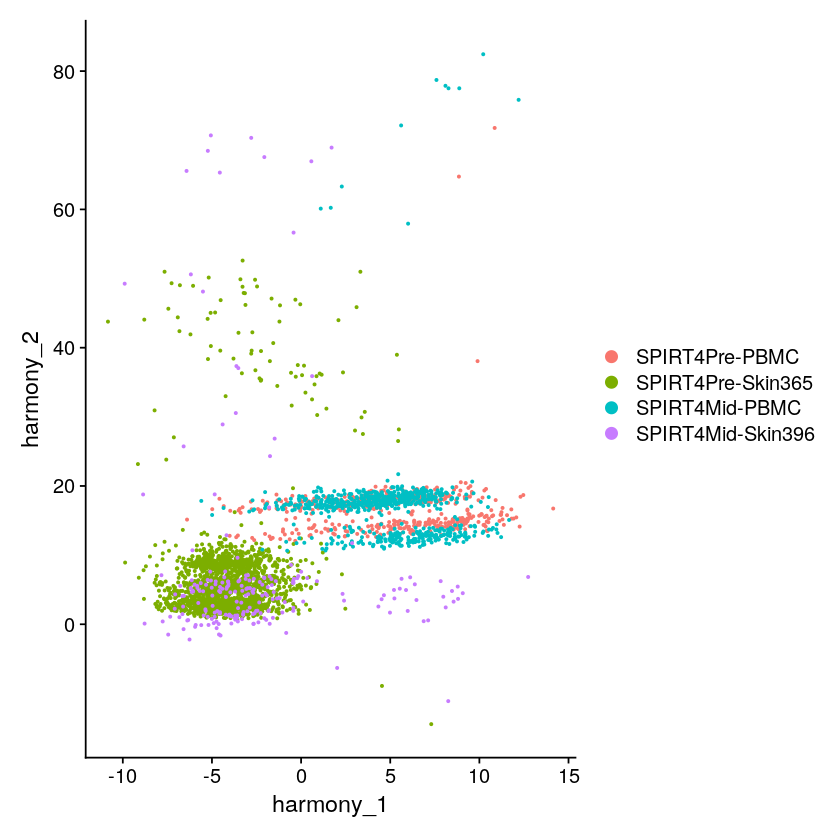

In [7]:
DimPlot(seurat, reduction="harmony")

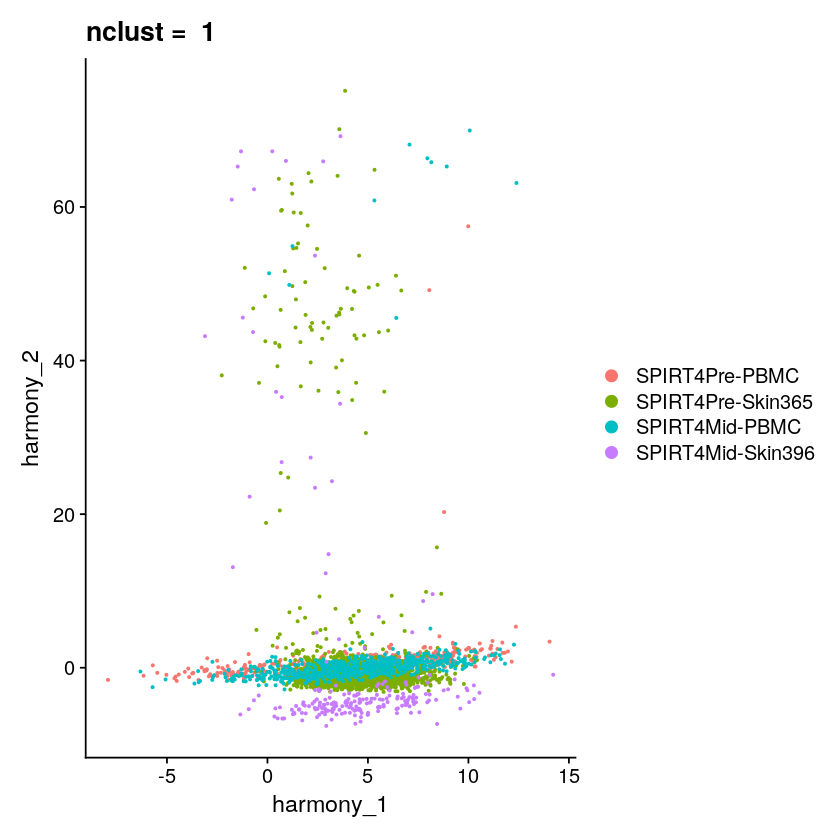

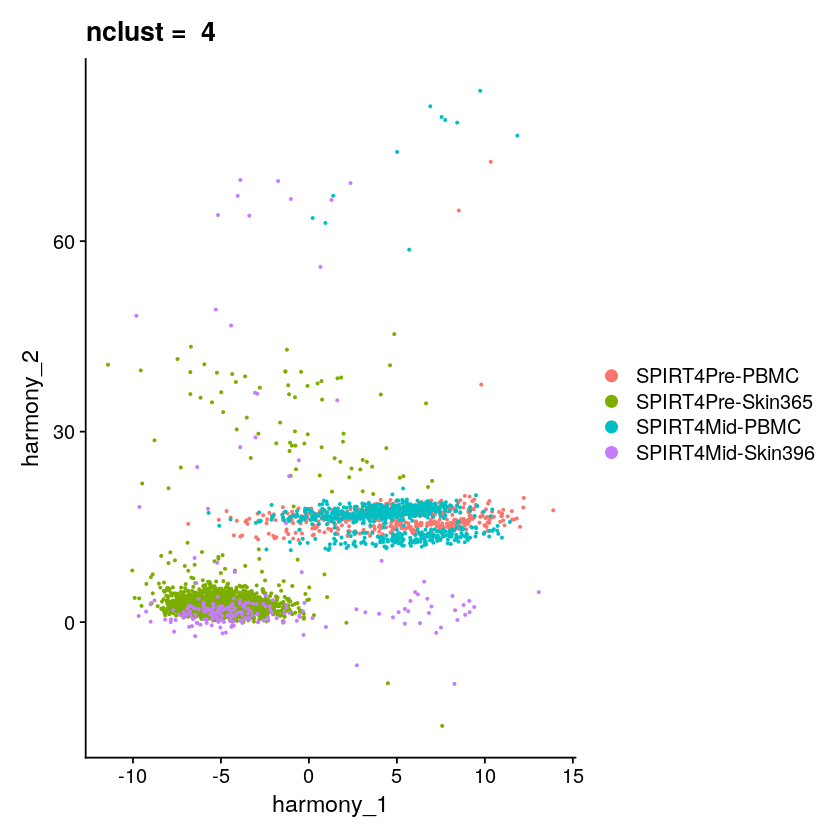

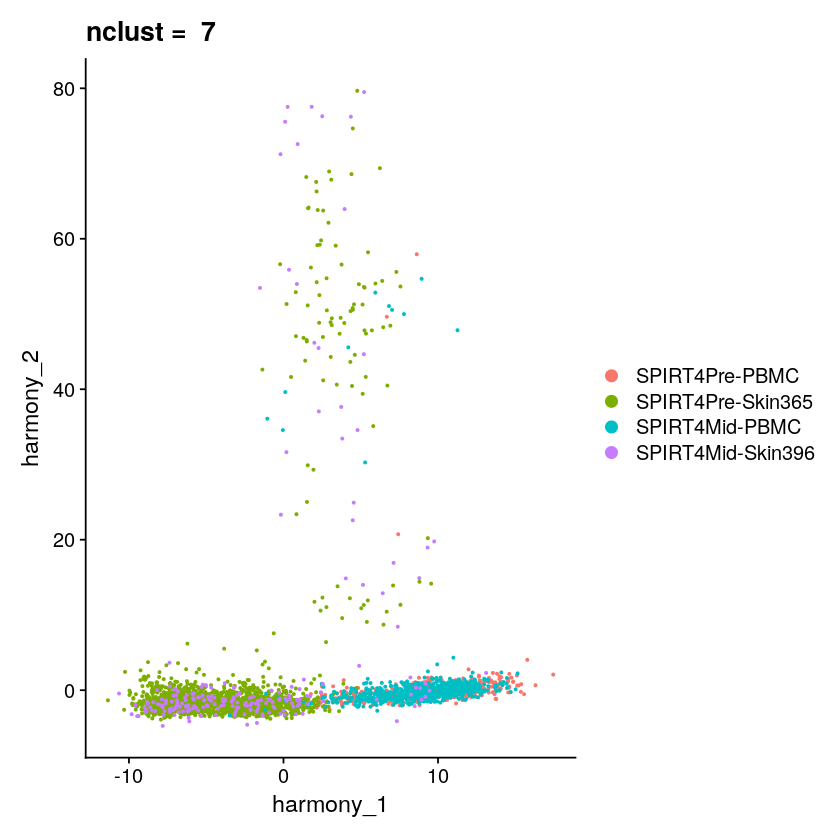

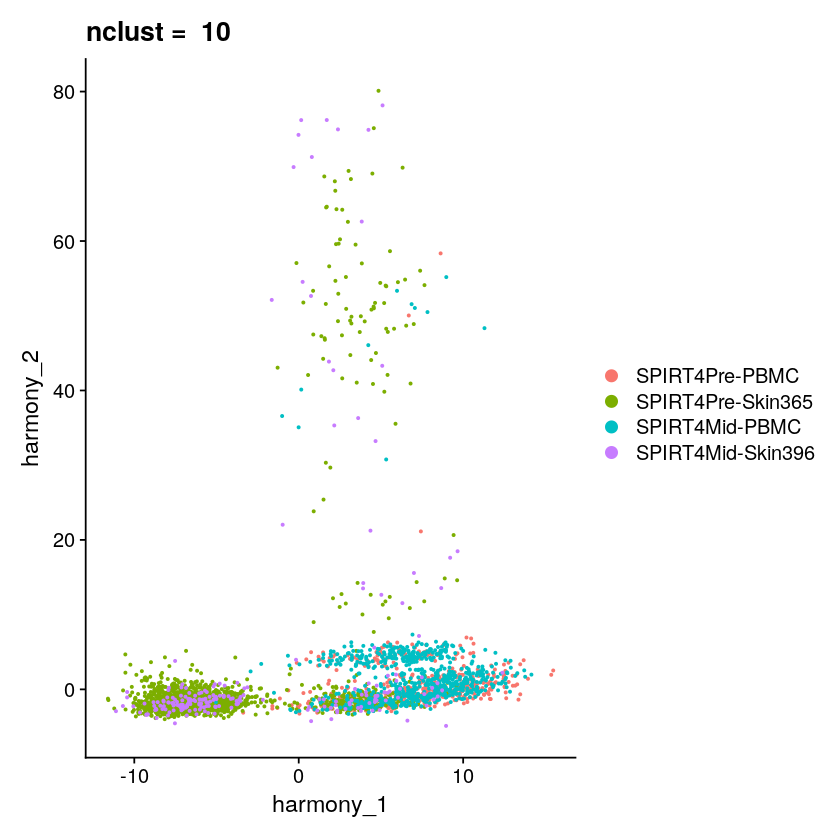

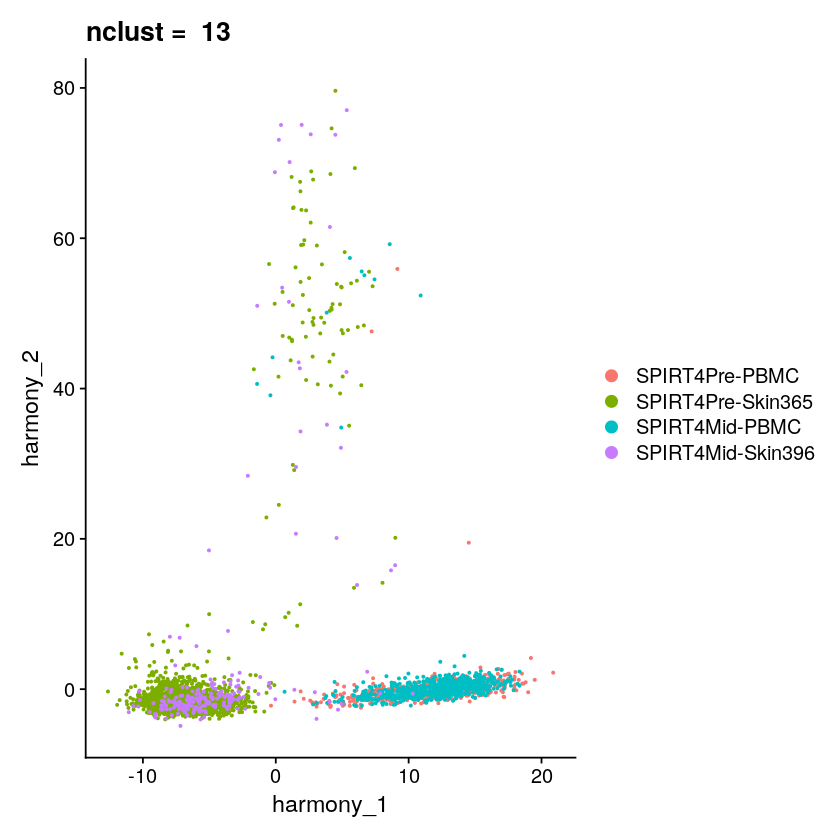

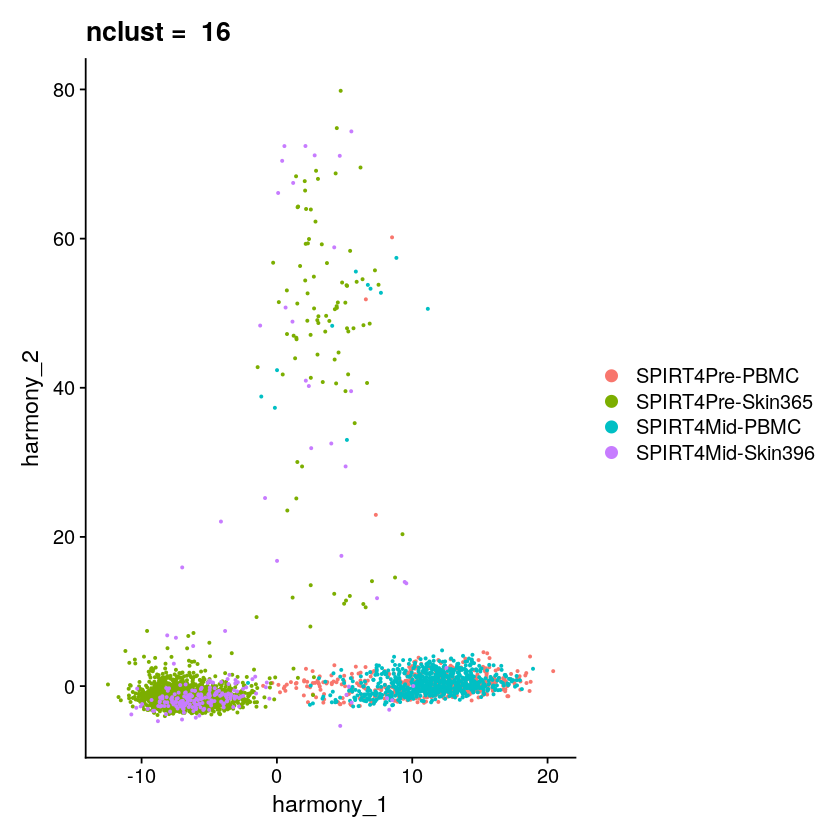

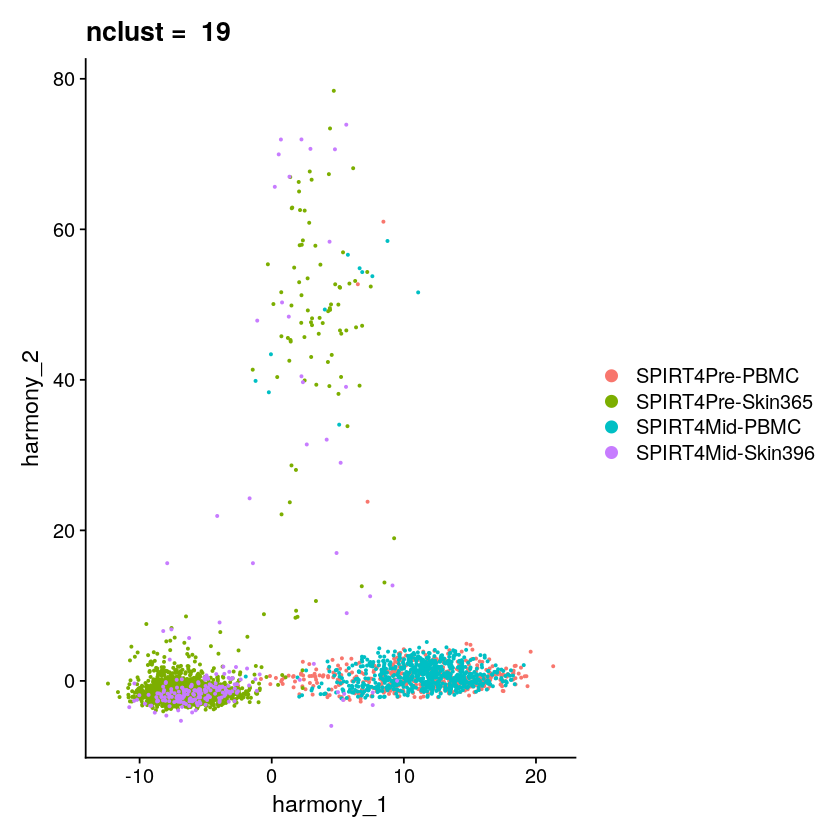

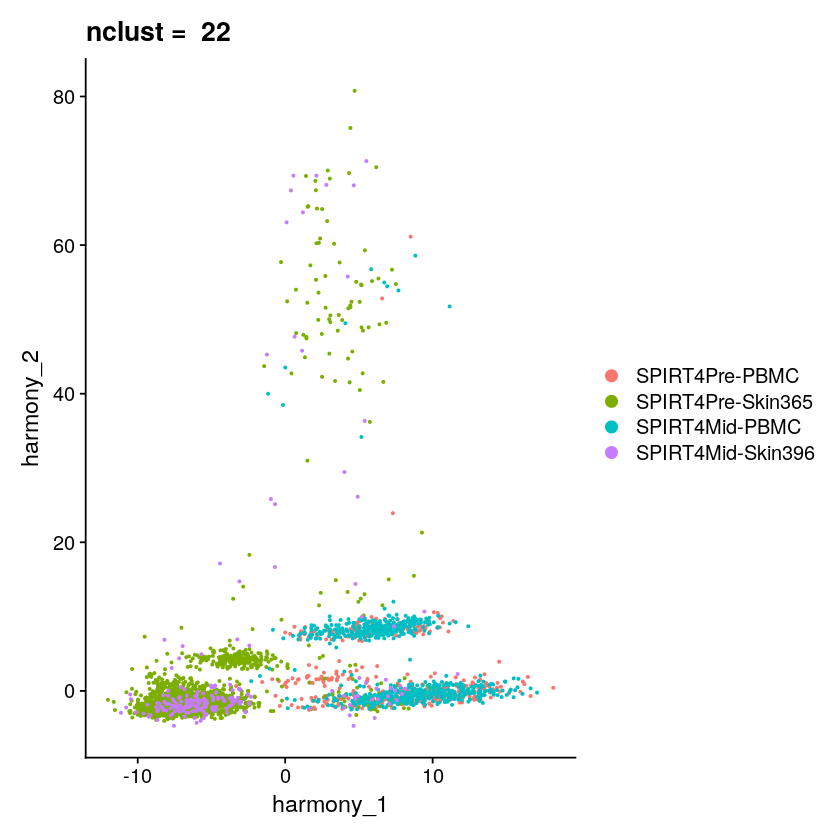

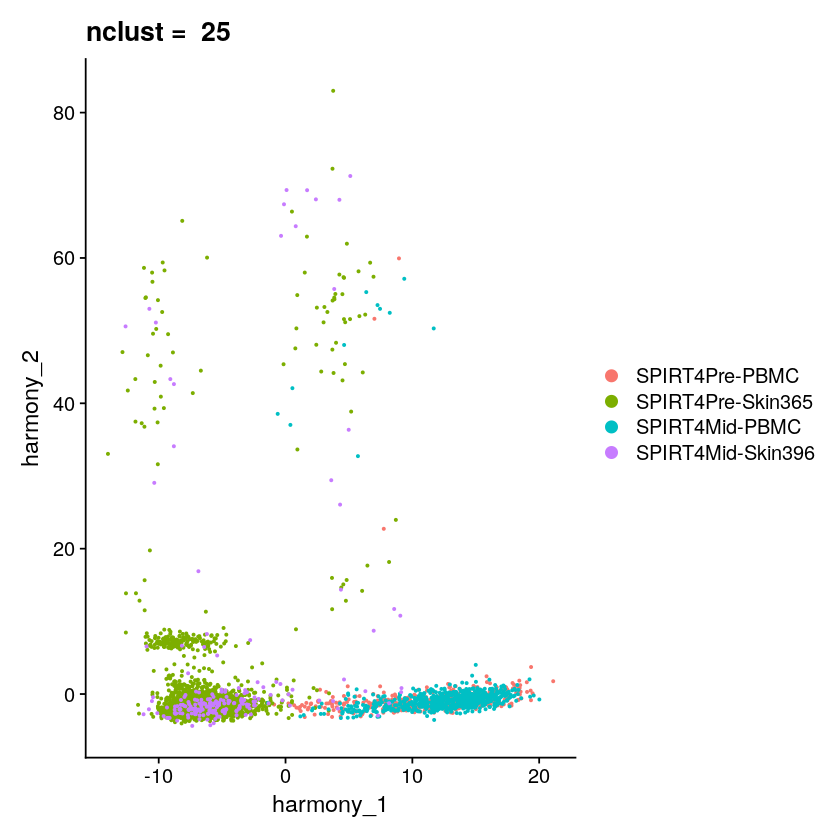

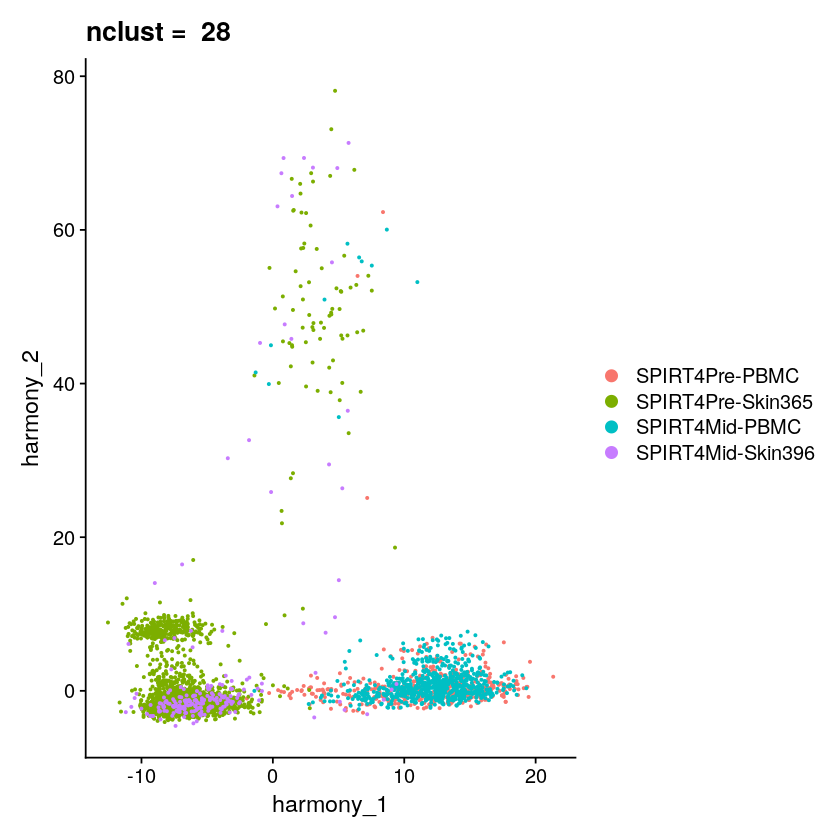

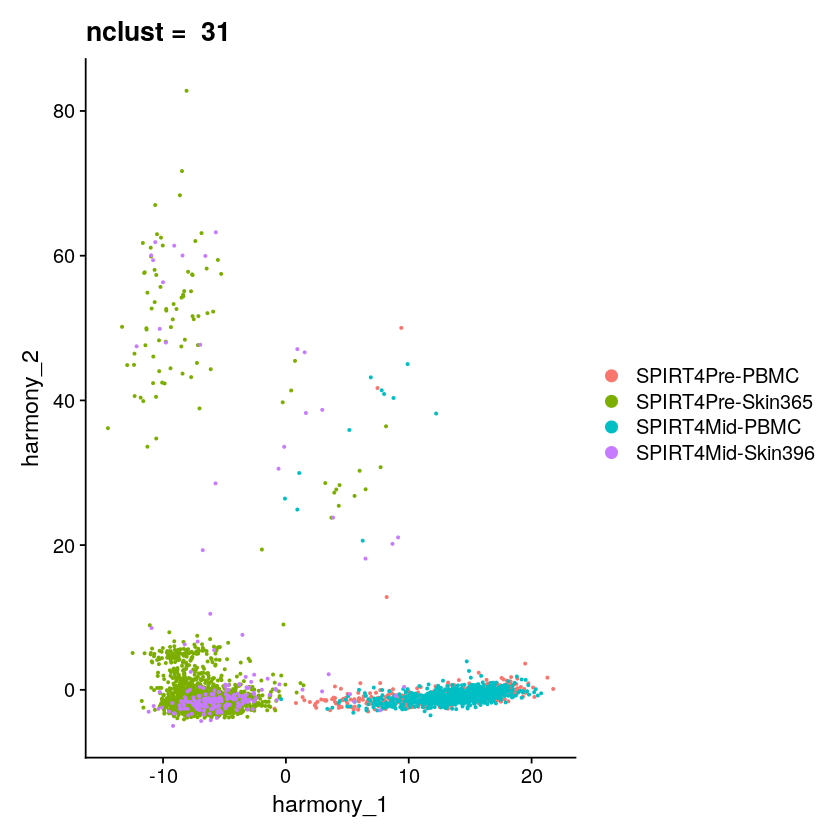

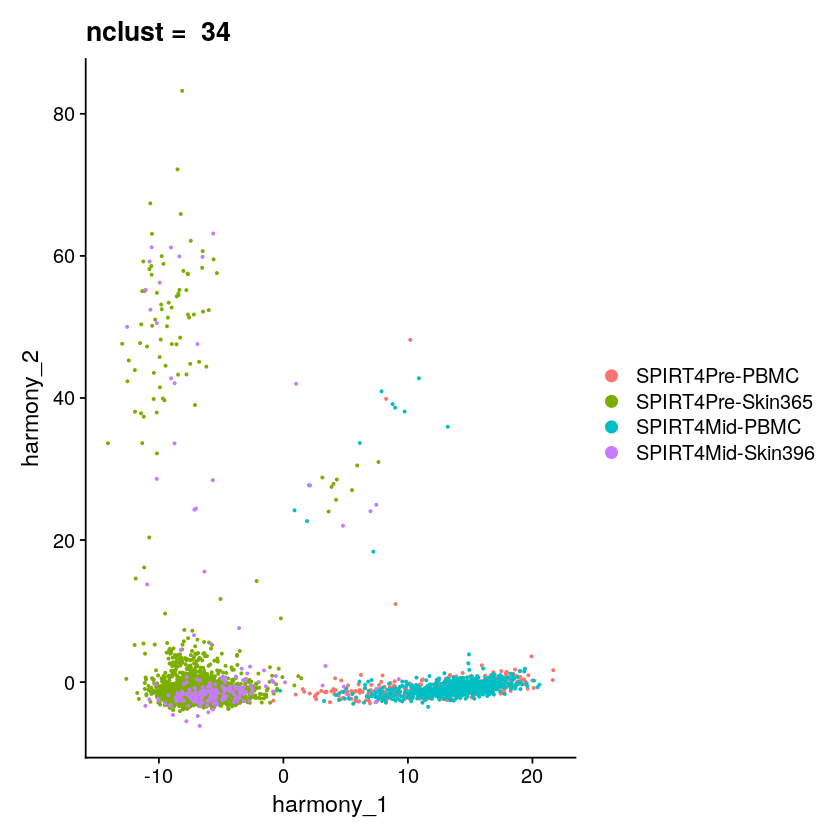

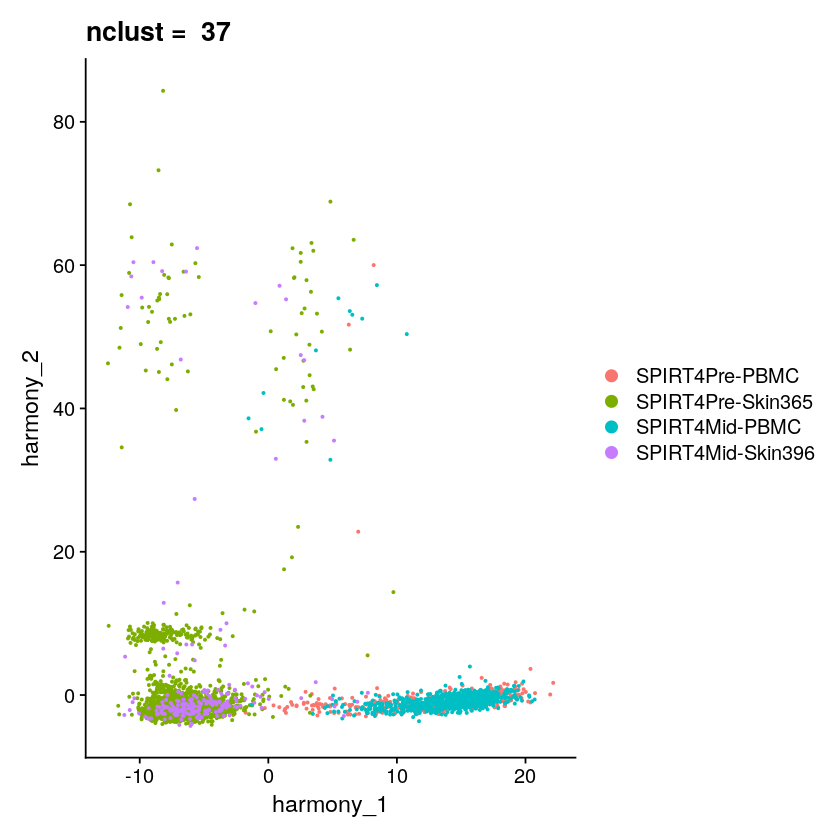

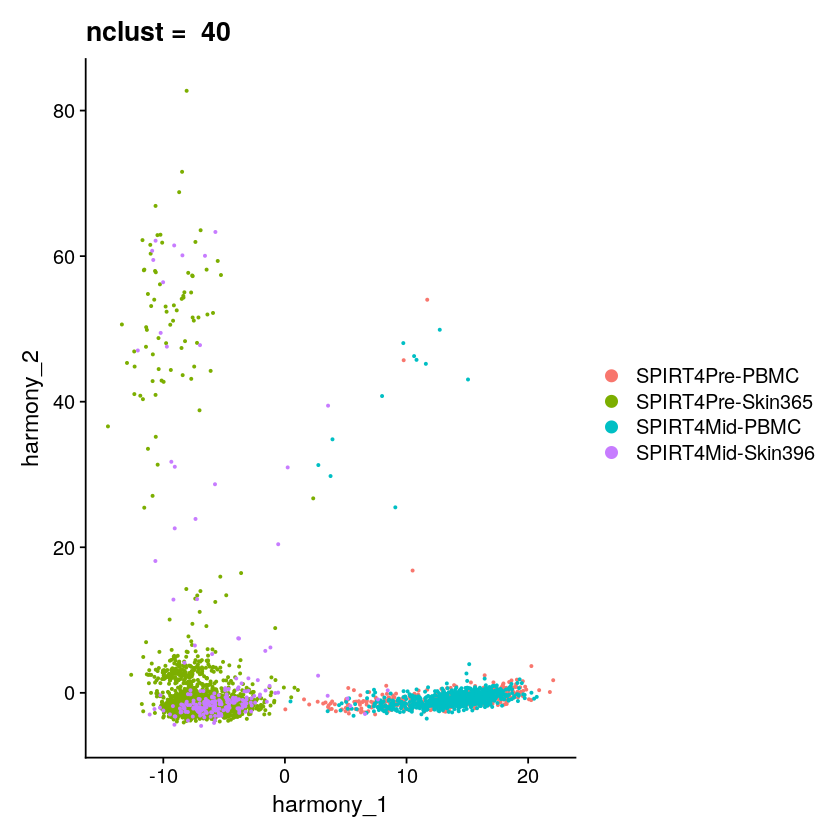

In [8]:
for (i in seq(1, 40, 3)) {
    seurat <- RunHarmony(seurat, "orig.ident", nclust=i, verbose=FALSE)
    print(DimPlot(seurat, reduction="harmony") + labs(title=paste("nclust = ", i)))
}